1 - SETUP

1.1 - Install Dependencies

In [1]:
pip install tensorflow opencv-python matplotlib

Note: you may need to restart the kernel to use updated packages.


1.2 - Import Dependencies

In [1]:
# Import standard dependencies
import cv2
import os
import shutil
from shutil import move
import random
import numpy as np
from matplotlib import pyplot as plt
from watchdog.observers import Observer
from watchdog.events import FileSystemEventHandler

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

1.3 - Set GPU Growth

In [6]:
# Avoid Out Of Memory(OOM) errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

1.4 - Create Folder Structures

In [9]:
# Setup paths
POS_PATH = '/Users/nikhiltripathi/Desktop/Face_detection/data/positive'
NEG_PATH = '/Users/nikhiltripathi/Desktop/Face_detection/data/negative'
ANC_PATH = '/Users/nikhiltripathi/Desktop/Face_detection/data/anchor'
LFW_PATH = '//Users/nikhiltripathi/Desktop/Face_detection/lfw'  

In [11]:
# Make the directories
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

2 - COLLECT POSITIVE AND ANCHORS

2.1 - Untar Labelled Faces in the Wild Dataset

" http://vis-www.cs.umass.edu/lfw/ "

In [16]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir(LFW_PATH):
        dir_path = os.path.join(LFW_PATH, directory)
        
        # Check if it's a directory
        if os.path.isdir(dir_path):
            print(f"Processing directory: {dir_path}")  # Debugging line
            
            for file in os.listdir(dir_path):
                EX_PATH = os.path.join(dir_path, file)
                NEW_PATH = os.path.join(NEG_PATH, file)

                # Move the file
                if shutil.move(EX_PATH, NEW_PATH):
                    print("done")
                    print(f'Moved: {EX_PATH} to {NEW_PATH}')  # Debugging line

Processing directory: //Users/nikhiltripathi/Desktop/Face_detection/lfw/German_Khan
Processing directory: //Users/nikhiltripathi/Desktop/Face_detection/lfw/Stefano_Gabbana
Processing directory: //Users/nikhiltripathi/Desktop/Face_detection/lfw/Dragan_Covic
Processing directory: //Users/nikhiltripathi/Desktop/Face_detection/lfw/Jeff_Hornacek
Processing directory: //Users/nikhiltripathi/Desktop/Face_detection/lfw/Sureyya_Ayhan
Processing directory: //Users/nikhiltripathi/Desktop/Face_detection/lfw/Deb_Santos
Processing directory: //Users/nikhiltripathi/Desktop/Face_detection/lfw/Bob_Newhart
Processing directory: //Users/nikhiltripathi/Desktop/Face_detection/lfw/Wang_Hailan
Processing directory: //Users/nikhiltripathi/Desktop/Face_detection/lfw/Paul_McNulty
Processing directory: //Users/nikhiltripathi/Desktop/Face_detection/lfw/Jimmy_Iovine
Processing directory: //Users/nikhiltripathi/Desktop/Face_detection/lfw/Claudia_Pechstein
Processing directory: //Users/nikhiltripathi/Desktop/Face_de

2.2 - Collect Positive and Anchor Classes

In [19]:
# Import uuid library to generate unique image names
import uuid

In [21]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'/Users/nikhiltripathi/Desktop/Face_detection/data/anchor/87aabba4-a950-11ef-93fe-2e86d9ef6111.jpg'

In [23]:
"""
# Check camera indices from 0 to 9
for i in range(10):
    cap = cv2.VideoCapture(i)
    
    if cap.isOpened():
        print(f"Camera found at index: {i}")
        cap.release()
        cv2.destroyAllWindows()  # Release the camera
    else:
        print(f"No camera found at index: {i}")"""

# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()

    #cutting frame to 250px X 250px
    frame = frame[120:120+250, 500:500+250, :]

    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    

    #show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()


2024-11-23 09:38:04.115 python[58302:4785663] +[IMKClient subclass]: chose IMKClient_Legacy
2024-11-23 09:38:04.115 python[58302:4785663] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


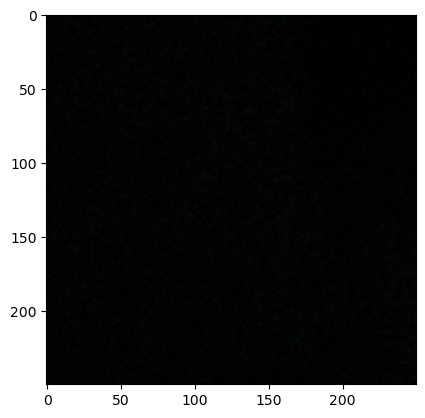

In [27]:
plt.imshow(frame) #frame[height, width, color]

2.x NEW - Data Augmentation

In [30]:
"""def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        data.append(img)
    
    return data"""

'def data_aug(img):\n    data = []\n    for i in range(9):\n        img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))\n        img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))\n        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))\n        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))\n        img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))\n        img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))\n            \n        data.append(img)\n    \n    return data'

In [32]:
import os
import uuid

In [34]:
"""img_path = os.path.join(ANC_PATH, '924e839c-135f-11ec-b54e-a0cec8d2d278.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())"""

"img_path = os.path.join(ANC_PATH, '924e839c-135f-11ec-b54e-a0cec8d2d278.jpg')\nimg = cv2.imread(img_path)\naugmented_images = data_aug(img)\n\nfor image in augmented_images:\n    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())"

In [36]:
"""for file_name in os.listdir(os.path.join(POS_PATH)):
    img_path = os.path.join(POS_PATH, file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img) 
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())"""

"for file_name in os.listdir(os.path.join(POS_PATH)):\n    img_path = os.path.join(POS_PATH, file_name)\n    img = cv2.imread(img_path)\n    augmented_images = data_aug(img) \n    \n    for image in augmented_images:\n        cv2.imwrite(os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())"

3 - Load and Preprocess Images

3.1 - Get Image Directories

In [55]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(450)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(450)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(450)

In [57]:
os.chdir('/Users/nikhiltripathi/Desktop/Face_detection/')

In [59]:
dir_test = anchor.as_numpy_iterator()

In [61]:
print(dir_test.next())

b'/Users/nikhiltripathi/Desktop/Face_detection/data/anchor/9d4cb8e2-a953-11ef-93fe-2e86d9ef6111.jpg'


3.2 - Preprocessing - Scale and Resize

In [64]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img/255.0
    
    return img

In [68]:
img = preprocess('/Users/nikhiltripathi/Desktop/Face_detection/data/anchor/9d4cb8e2-a953-11ef-93fe-2e86d9ef6111.jpg')

In [70]:
img.numpy().min()

0.0

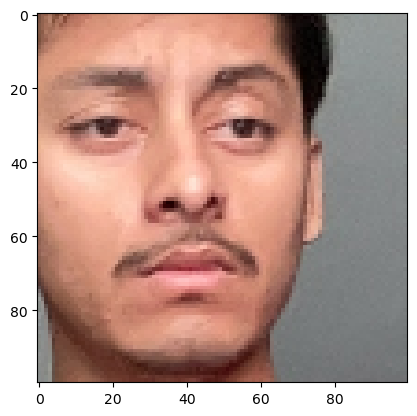

In [72]:
plt.imshow(img)

In [74]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

3.3 - Create Labelled Dataset

In [77]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [79]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives) #joining +ive and -ive data together

In [81]:
samples = data.as_numpy_iterator()

In [83]:
example = samples.next()

In [85]:
example

(b'/Users/nikhiltripathi/Desktop/Face_detection/data/anchor/e35e0390-a953-11ef-93fe-2e86d9ef6111.jpg',
 b'/Users/nikhiltripathi/Desktop/Face_detection/data/positive/2e534d28-a8fb-11ef-8b34-2e86d9ef6111.jpg',
 1.0)

3.4 - Build Train and Test Partition

In [88]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [90]:
res = preprocess_twin(*example) # "*" helps in  unpacking the items from the tuple

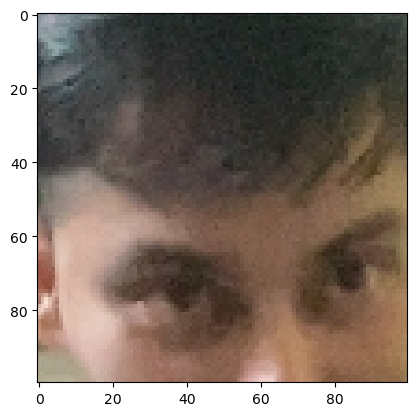

In [92]:
plt.imshow(res[1])

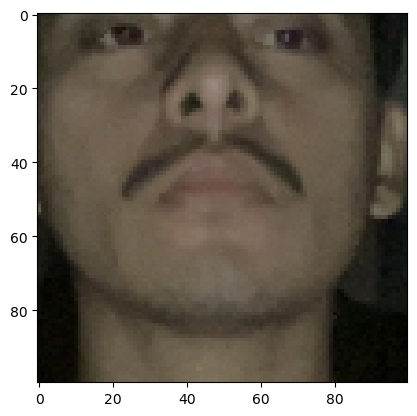

In [94]:
plt.imshow(res[0])

In [96]:
res[2]

1.0

In [98]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [100]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [102]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

4 - Model Engineering

4.1 - Build Embedding Layer

In [106]:
inp = Input(shape=(100,100,3), name='input_image')

In [108]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [110]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [112]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [114]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [116]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [118]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [120]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [122]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [124]:
embedding = make_embedding()

In [126]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

4.2 - Build Distance Layer

In [129]:
# Siamese L1 Distance class
"""class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)"""
import tensorflow as tf
from tensorflow.keras.layers import Layer

class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        # Ensure both inputs are tensors
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        
        # Calculate L1 distance
        return tf.math.abs(input_embedding - validation_embedding)

In [131]:
l1 = L1Dist()

In [133]:
l1(anchor_embedding, validation_embedding)

NameError: name 'anchor_embedding' is not defined

4.3 - Make Siamese Model

In [136]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [138]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [140]:
siamese_layer = L1Dist()

In [142]:
distances = siamese_layer(inp_embedding, val_embedding)

In [144]:
classifier = Dense(1, activation='sigmoid')(distances)

In [146]:
classifier

<KerasTensor shape=(1, None, 1), dtype=float32, sparse=False, name=keras_tensor_21>

In [148]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [150]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [152]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [154]:
siamese_model = make_siamese_model()

In [156]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[2][0],  │
│                     │                   │            │ embedding[3][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

5 - Training

5.1 - Setup Loss and Optimizer

In [160]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [162]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

5.2 - Establish Checkpoints

In [165]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

5.3 - Build Train Step Function

In [168]:
test_batch = train_data.as_numpy_iterator()

In [170]:
batch_1 = test_batch.next()

In [171]:
X = batch_1[:2]

In [174]:
y = batch_1[2]

In [176]:
y

array([1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.],
      dtype=float32)

In [178]:
tf.losses.BinaryCrossentropy??

Init signature:
tf.losses.BinaryCrossentropy(
    from_logits=False,
    label_smoothing=0.0,
    axis=-1,
    reduction='sum_over_batch_size',
    name='binary_crossentropy',
    dtype=None,
)
Source:        
@keras_export("keras.losses.BinaryCrossentropy")
class BinaryCrossentropy(LossFunctionWrapper):
    """Computes the cross-entropy loss between true labels and predicted labels.

    Use this cross-entropy loss for binary (0 or 1) classification applications.
    The loss function requires the following inputs:

    - `y_true` (true label): This is either 0 or 1.
    - `y_pred` (predicted value): This is the model's prediction, i.e, a single
        floating-point value which either represents a
        [logit](https://en.wikipedia.org/wiki/Logit), (i.e, value in [-inf, inf]
        when `from_logits=True`) or a probability (i.e, value in [0., 1.] when
        `from_logits=False`).

    Args:
        from_logits: Whether to interpret `y_pred` as a tensor of
            [logit](htt

In [180]:
@tf.function
def train_step(batch):
    
    # Record all operations for gradient calculation
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        
        # Reshape yhat or y to match each other
        yhat = tf.squeeze(yhat)  # Adjust as per requirement
        loss = binary_cross_loss(y, yhat)
        
    print("Loss:", loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Apply gradients to update model weights
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return the computed loss
    return loss

5.4 - Build Training Loop

In [185]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [187]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

5.5 - Train the model

In [190]:
EPOCHS = 50

In [192]:
train(train_data, EPOCHS)


 Epoch 1/50
Loss: Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_img', 'validation_img']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['input_image']. Received: the structure of inputs=*
  warnings.warn(


Loss: Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━

2024-11-23 10:21:28.642990: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step/ste
1/1 ━━━━

2024-11-23 10:32:42.170211: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/

2024-11-23 10:53:12.637212: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/

2024-11-23 11:34:17.558000: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/

2024-11-23 12:57:35.832683: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/

6 - Evaluate Model

6.1 - Import Metrics

In [216]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

6.2 - Make Predictions

In [219]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [221]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [223]:
# Post processing the results 
# Use prediction > 0.5 element-wise and convert to int (1 or 0)
results = [1 if prediction > 0.5 else 0 for prediction in y_hat.ravel()]

In [225]:
y_true

array([1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0.],
      dtype=float32)

6.3 - Calculate Metrics

In [228]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [230]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [232]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1.0 1.0


6.4 - Viz Results

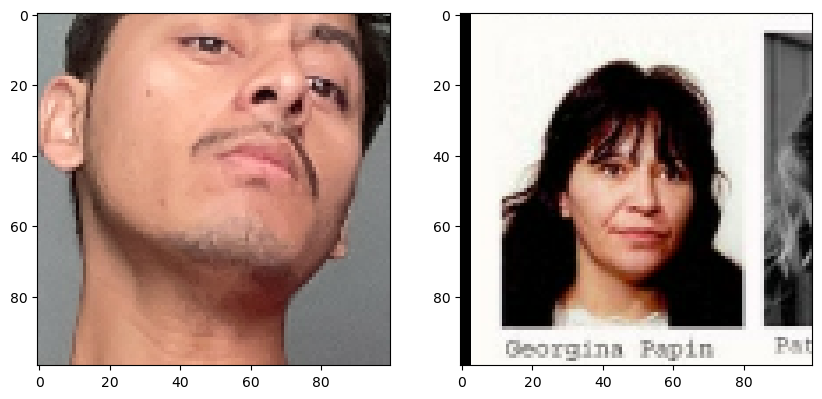

In [235]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[3])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[3])

# Renders cleanly
plt.show()

7 - Save Model

In [238]:
# Save model in the recommended Keras format
siamese_model.save('/Users/nikhiltripathi/Desktop/Face_detection/app/siamesemodel.h5')

In [240]:
L1Dist

__main__.L1Dist

In [242]:
# Reload model 
siamese_model = tf.keras.models.load_model('/Users/nikhiltripathi/Desktop/Face_detection/app/siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [244]:
siamese_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Use the same optimizer as in training
    loss=tf.losses.BinaryCrossentropy(),                     # Use the same loss function
    metrics=['accuracy']                                      # Add metrics if needed
)

In [246]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


array([[[7.6650613e-05],
        [9.9954683e-01],
        [9.9548101e-01],
        [4.8828895e-07],
        [1.0000000e+00],
        [4.1774674e-06],
        [1.0000000e+00],
        [1.0000000e+00],
        [9.9948144e-01],
        [7.8755969e-05],
        [7.3356459e-06],
        [4.1616891e-04],
        [8.4321066e-05],
        [1.0000000e+00]]], dtype=float32)

In [248]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_3 (L1Dist)  │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

8 - Real Time Test

8.1 - Verification Function

In [252]:
app_data ='/Users/nikhiltripathi/Desktop/Face_detection/application_data/'

In [254]:
os.listdir(os.path.join(app_data, 'verification_images'))

['db682864-8716-11ef-85d0-2e86d9ef6111.jpg',
 'a7e1d8a4-a76a-11ef-9964-2e86d9ef6111.jpg',
 'eb3204a4-8716-11ef-85d0-2e86d9ef6111.jpg',
 'dce56ed6-8716-11ef-85d0-2e86d9ef6111.jpg',
 'a598edda-a76a-11ef-9964-2e86d9ef6111.jpg',
 '8eeccc42-8716-11ef-85d0-2e86d9ef6111.jpg',
 'a8e01554-a76a-11ef-9964-2e86d9ef6111.jpg',
 'db9acf3a-8716-11ef-85d0-2e86d9ef6111.jpg',
 '7a8c106e-8716-11ef-85d0-2e86d9ef6111.jpg',
 '7dd349ae-8716-11ef-85d0-2e86d9ef6111.jpg',
 '7aa56816-8716-11ef-85d0-2e86d9ef6111.jpg',
 'e81db9fc-8716-11ef-85d0-2e86d9ef6111.jpg',
 'd7ac13b6-8716-11ef-85d0-2e86d9ef6111.jpg',
 'b7e039e0-8716-11ef-85d0-2e86d9ef6111.jpg',
 'a9de4e62-a76a-11ef-9964-2e86d9ef6111.jpg',
 '7a59872a-8716-11ef-85d0-2e86d9ef6111.jpg',
 '97dcfb4c-8716-11ef-85d0-2e86d9ef6111.jpg',
 'b845c206-8716-11ef-85d0-2e86d9ef6111.jpg',
 'a63153c2-a76a-11ef-9964-2e86d9ef6111.jpg',
 '.DS_Store',
 'ab0f5272-a76a-11ef-9964-2e86d9ef6111.jpg',
 'dee1eca0-8716-11ef-85d0-2e86d9ef6111.jpg',
 'a4354d9e-a76a-11ef-9964-2e86d9ef6111.jp

In [256]:
os.path.join(app_data, 'input_image', 'input_image.jpg')

'/Users/nikhiltripathi/Desktop/Face_detection/application_data/input_image/input_image.jpg'

In [258]:
for image in os.listdir(os.path.join(app_data, 'verification_images')):
    validation_img = os.path.join(app_data, 'verification_images', image)
    print(validation_img)

/Users/nikhiltripathi/Desktop/Face_detection/application_data/verification_images/db682864-8716-11ef-85d0-2e86d9ef6111.jpg
/Users/nikhiltripathi/Desktop/Face_detection/application_data/verification_images/a7e1d8a4-a76a-11ef-9964-2e86d9ef6111.jpg
/Users/nikhiltripathi/Desktop/Face_detection/application_data/verification_images/eb3204a4-8716-11ef-85d0-2e86d9ef6111.jpg
/Users/nikhiltripathi/Desktop/Face_detection/application_data/verification_images/dce56ed6-8716-11ef-85d0-2e86d9ef6111.jpg
/Users/nikhiltripathi/Desktop/Face_detection/application_data/verification_images/a598edda-a76a-11ef-9964-2e86d9ef6111.jpg
/Users/nikhiltripathi/Desktop/Face_detection/application_data/verification_images/8eeccc42-8716-11ef-85d0-2e86d9ef6111.jpg
/Users/nikhiltripathi/Desktop/Face_detection/application_data/verification_images/a8e01554-a76a-11ef-9964-2e86d9ef6111.jpg
/Users/nikhiltripathi/Desktop/Face_detection/application_data/verification_images/db9acf3a-8716-11ef-85d0-2e86d9ef6111.jpg
/Users/nikhiltri

In [260]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join(app_data, 'verification_images')):
        input_img = preprocess(os.path.join(app_data, 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join(app_data, 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join(app_data, 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

8.2 - OpenCV Real Time Verification

In [263]:
import cv2
import os

# Define the folder where the image will be saved
input_image_path = os.path.join(app_data, 'input_image')

# Create the directory if it doesn't exist
if not os.path.exists(input_image_path):
    os.makedirs(input_image_path)

cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    
    # Define the region of interest (ROI)
    frame = frame[120:120+250, 500:500+250]
    
    # Show the frame in the window
    cv2.imshow('Verification', frame)
    
    # Capture the key press once
    key = cv2.waitKey(10) & 0xFF
    
    # If 'v' is pressed, save/overwrite the image
    if key == ord('v'):
        # Save the image to the 'input_image' folder, overwriting the previous one
        img_path = os.path.join(input_image_path, 'input_image.jpg')
        if cv2.imwrite(img_path, frame):
            print(f"Image successfully saved at {img_path}")
        else:
            print(f"Failed to save the image at {img_path}")
        
        # Run verification (assuming verify function is defined)
        try:
            results, verified = verify(siamese_model, 0.5, 0.5)  # Adjust the arguments as needed
            print(verified)
        except Exception as e:
            print(f"Error during verification: {e}")
    
    # If 'q' is pressed, exit the loop
    if key == ord('q'):
        break

# Release the camera and close windows
cap.release()
cv2.destroyAllWindows()

Image successfully saved at /Users/nikhiltripathi/Desktop/Face_detection/application_data/input_image/input_image.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Error during verification: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file for

In [264]:
np.sum(np.squeeze(results) < 0.9)

6

In [267]:
results

[1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0]